# "League Champion Relationships"
## "Santiago Torres"
## "October 21, 2016"

In [175]:
library(png)
library(igraph)
library(jsonlite)
library(repr)
path_to_files = "C:/Users/TORRES_SANT/Documents/Programming/webscrapping/champion_relationships/R_analysis/img"

## Introduction

Give an interpretation of the results of each computation.

Direct the reader's attention to the features you want them to observe in each plot.

If your plots and comptuations allow you to draw any conclusions about your data, do so.

Perform at least one computation.

We discussed some network and vertex measures in class on 10/17, but there are others documented in the igraph manual.
Furthermore, you can do other computations in R using any of the code you've learned to write earlier in our course.

***For instance, you might compute the betweenness centrality of your vertices, if the interpretation of that measure discussed in class on 10/17 is relevant to your network.***

***Provide a clear write-up of all the (non-boring) things you did on this project.***

***How did you plan and execute the data gathering?***

***What difficulties (if any) arose when you tried to represent your data clearly as a graph?***

  images, json files
  
***What computation did you do and why do you think its results mean?***

***Why are they informative or interesting for your network?***


### How I got my data

I chose to use Riot Games: League of Legends Champion relationships as the Social Network for the project.

I did not want to spend a couple hours going through the champion pages and grabbing the relationships, so I wrote a webscrapping script in Python that queries the Riot API for a list of all the champions and then scrapes all the champion relationship information from the relevant url.

All of this data was then downloaded into a JSON file similar to this format:

  {
  
    Champion_name:
    
    Faction:
  
    Rivals:
  
    Friends:
  
  }

Feel free to take a look at my [champion_relationships](https://github.com/sserrot/champion_relationships) repository on GitHub for more information on that process.

#### Lets take a look at the data we got in our newly created .json file.

I use the `jsonlite` package to read the champions.json file into a dataframe of lists


In [176]:
champ_relations = fromJSON("champions.json")

##### Number of Champions

In [177]:
numChampions <- nrow(champ_relations)
numChampions

[1] 133

#### Column Names

In [178]:
colnames(champ_relations)

[1] "friends"       "champion_name" "faction"       "rivals"

I changed the order of the columns to better represent the data.

In [179]:
newchamp_relations <- champ_relations[,c(2,3,1,4)]

Here is the first problem I encountered in the dataset:

  a. Working with *JSON*


In [180]:
testVertexNames <- as.vector(newchamp_relations$champion_name)
head(testVertexNames)

[[1]]
[1] "Aatrox"

[[2]]
[1] "AurelionSol"

[[3]]
[1] "Anivia"

[[4]]
[1] "Akali"

[[5]]
[1] "Ashe"

[[6]]
[1] "Amumu"

As you can see, the information is embedded into the lists in the dataframe, so we have to iterate through it to get the information. 

## Creating the graph requirements

### Vertex creation

#### Vertex names

In [181]:
vertexNames <- c()

for (champ in newchamp_relations$champion_name){
  vertexNames = c(vertexNames,tolower(champ))
}
# there is a champion that has a relationship with a nonchampion so add the nonchampion.

vertexNames = c(vertexNames, "skaarl")

### Creating Connections/Edges

#### Friends edges creation

Now we should store the relationships, or edges, in order to graph our Social Network.

In order to add our edges of friends, we have to iterate through the dataframe again, storing the friends information.

since JSON stores multiple friends in one pair with their respective champion, we cannot use the same iteration method we used for the vertex names.

Edges are also more complex because we have to store the champion with its edge so there must be a Source list and a Target list. 

Here is the code for the friends edges

In [182]:
edgeFriendsSource <- c() #empty edge for loop
edgeFriendsTarget <- c()

i = 1
f = 1

while(i <= numChampions) {
  champName = newchamp_relations$champion_name[[i]]
  numFriends = length(newchamp_relations$friends[[i]])
  
  while (numFriends > 0 && f <= numFriends){
    if (newchamp_relations$friends[[i]][f] != "")
      {
      edgeFriendsSource = c(edgeFriendsSource,tolower(champName))
      edgeFriendsTarget = c(edgeFriendsTarget, tolower(newchamp_relations$friends[[i]][f]))
    }
    f = f + 1
    }
  f = 1
  i = i +1
}

head(edgeFriendsSource)
head(edgeFriendsTarget)


[1] "anivia" "anivia" "akali"  "akali"  "ashe"   "ashe"

[1] "ashe"       "nunu"       "shen"       "kennen"     "tryndamere"
[6] "anivia"

### Create Faction Attributes

Lets create the attributes for the faction of champions.

This is to make the graph slightly more interesting so we can see if relationships are clustered by faction.

In [183]:
i = 1
f = 1
edgeFactionSource <- c()
edgeFactionTarget <- c()

while(i <= numChampions) {
  for (faction in newchamp_relations$faction){
    if (f <= (numChampions)) {
      if (newchamp_relations$faction[[f]] !="" && f <= (numChampions)) # we have to check Skaarl who has no faction
      {
        champName = newchamp_relations$champion_name[[f]] #133
        edgeFactionSource = c(edgeFactionSource, tolower(champName))
        edgeFactionTarget = c(edgeFactionTarget, newchamp_relations$faction[[f]])
      }
      f = f + 1
    }
  }
  i = i+1
}
head(edgeFactionSource)
head(edgeFactionTarget)

[1] "aatrox" "anivia" "akali"  "ashe"   "amumu"  "azir"

[1] "Independent" "Freljord"    "Ionia"       "Freljord"    "BandleCity" 
[6] "Shurima"

### Rivals edges creation
Lets create the rival connections for the graph.

There was another error thrown later in the graphing due to improper champion naming.

That is fixed by the last line where I replace `monkeyking` with `wukong`

You'll notice it is only one list instead of two like the others.
This is because `friends` and `factions` will be dataframes, but `rivals` must be a list in order to use
`add_edges` later in the graphing process.

In [184]:
edgeRivals <- c() #empty edge for loop

i = 1
f = 1

while(i <= numChampions) {
  
  champName = newchamp_relations$champion_name[[i]]
  
  numRivals = length(newchamp_relations$rivals[[i]])
  
  while (numRivals > 0 && f <= numRivals){
    if (newchamp_relations$rivals[[i]][f] !="")
      {
      edgeRivals = c(edgeRivals,tolower(champName), tolower(newchamp_relations$rivals[[i]][f]))
    }
    f = f + 1
    }
  f = 1
  i = i +1
}
edgeRivals[276] = "wukong" # it was labeled as monkeyking, which threw errors in the graph

## Graphing the data

Here are all the global variables for the graphing portion

In [185]:
# globals
vertexSize <- 7
vLabelSize <- 1
vLabelDist <- 0
vLabelColor <- "darkblue"
vLabelFont <- 2 # bold text
vLabelDegree = -pi/2
eArrowSize <- .3
eArrowWidth<- .7

In [186]:
# Graphing both relationships
dfEdge = as.data.frame(edgeFriendsSource, stringsAsFactors=FALSE)
dfEdge["friendsTarget"] = edgeFriendsTarget

# vertex dataframe
dfVertex = as.data.frame(vertexNames, stringsAsFactors=FALSE)
dfVertex["ID"] = vertexNames

both = graph_from_data_frame(d=dfEdge, vertices = dfVertex, directed = T)
E(both)$color <- "darkgreen" # green for friends
both <- add_edges(both, edgeRivals, attr=list(color="red")) #red for enemies

[1] "Independent" NA            "Freljord"    "Ionia"       "Freljord"   
[6] "BandleCity"

[1] "Independent"       NA                  "Freljord"         
 [4] "Ionia"             "BandleCity"        "Shurima"          
 [7] "Zaun"              "Piltover"          "ShurimaNoxus"     
[10] "Void"              "Noxus"             "MtTargon"         
[13] "ShadowIsles"       "Demacia"           "Bilgewater"       
[16] "IoniaBandleCity"   "BandleCityDemacia" "DemaciaIonia"     
[19] "FreljordIonia"     "NoxusZaun"

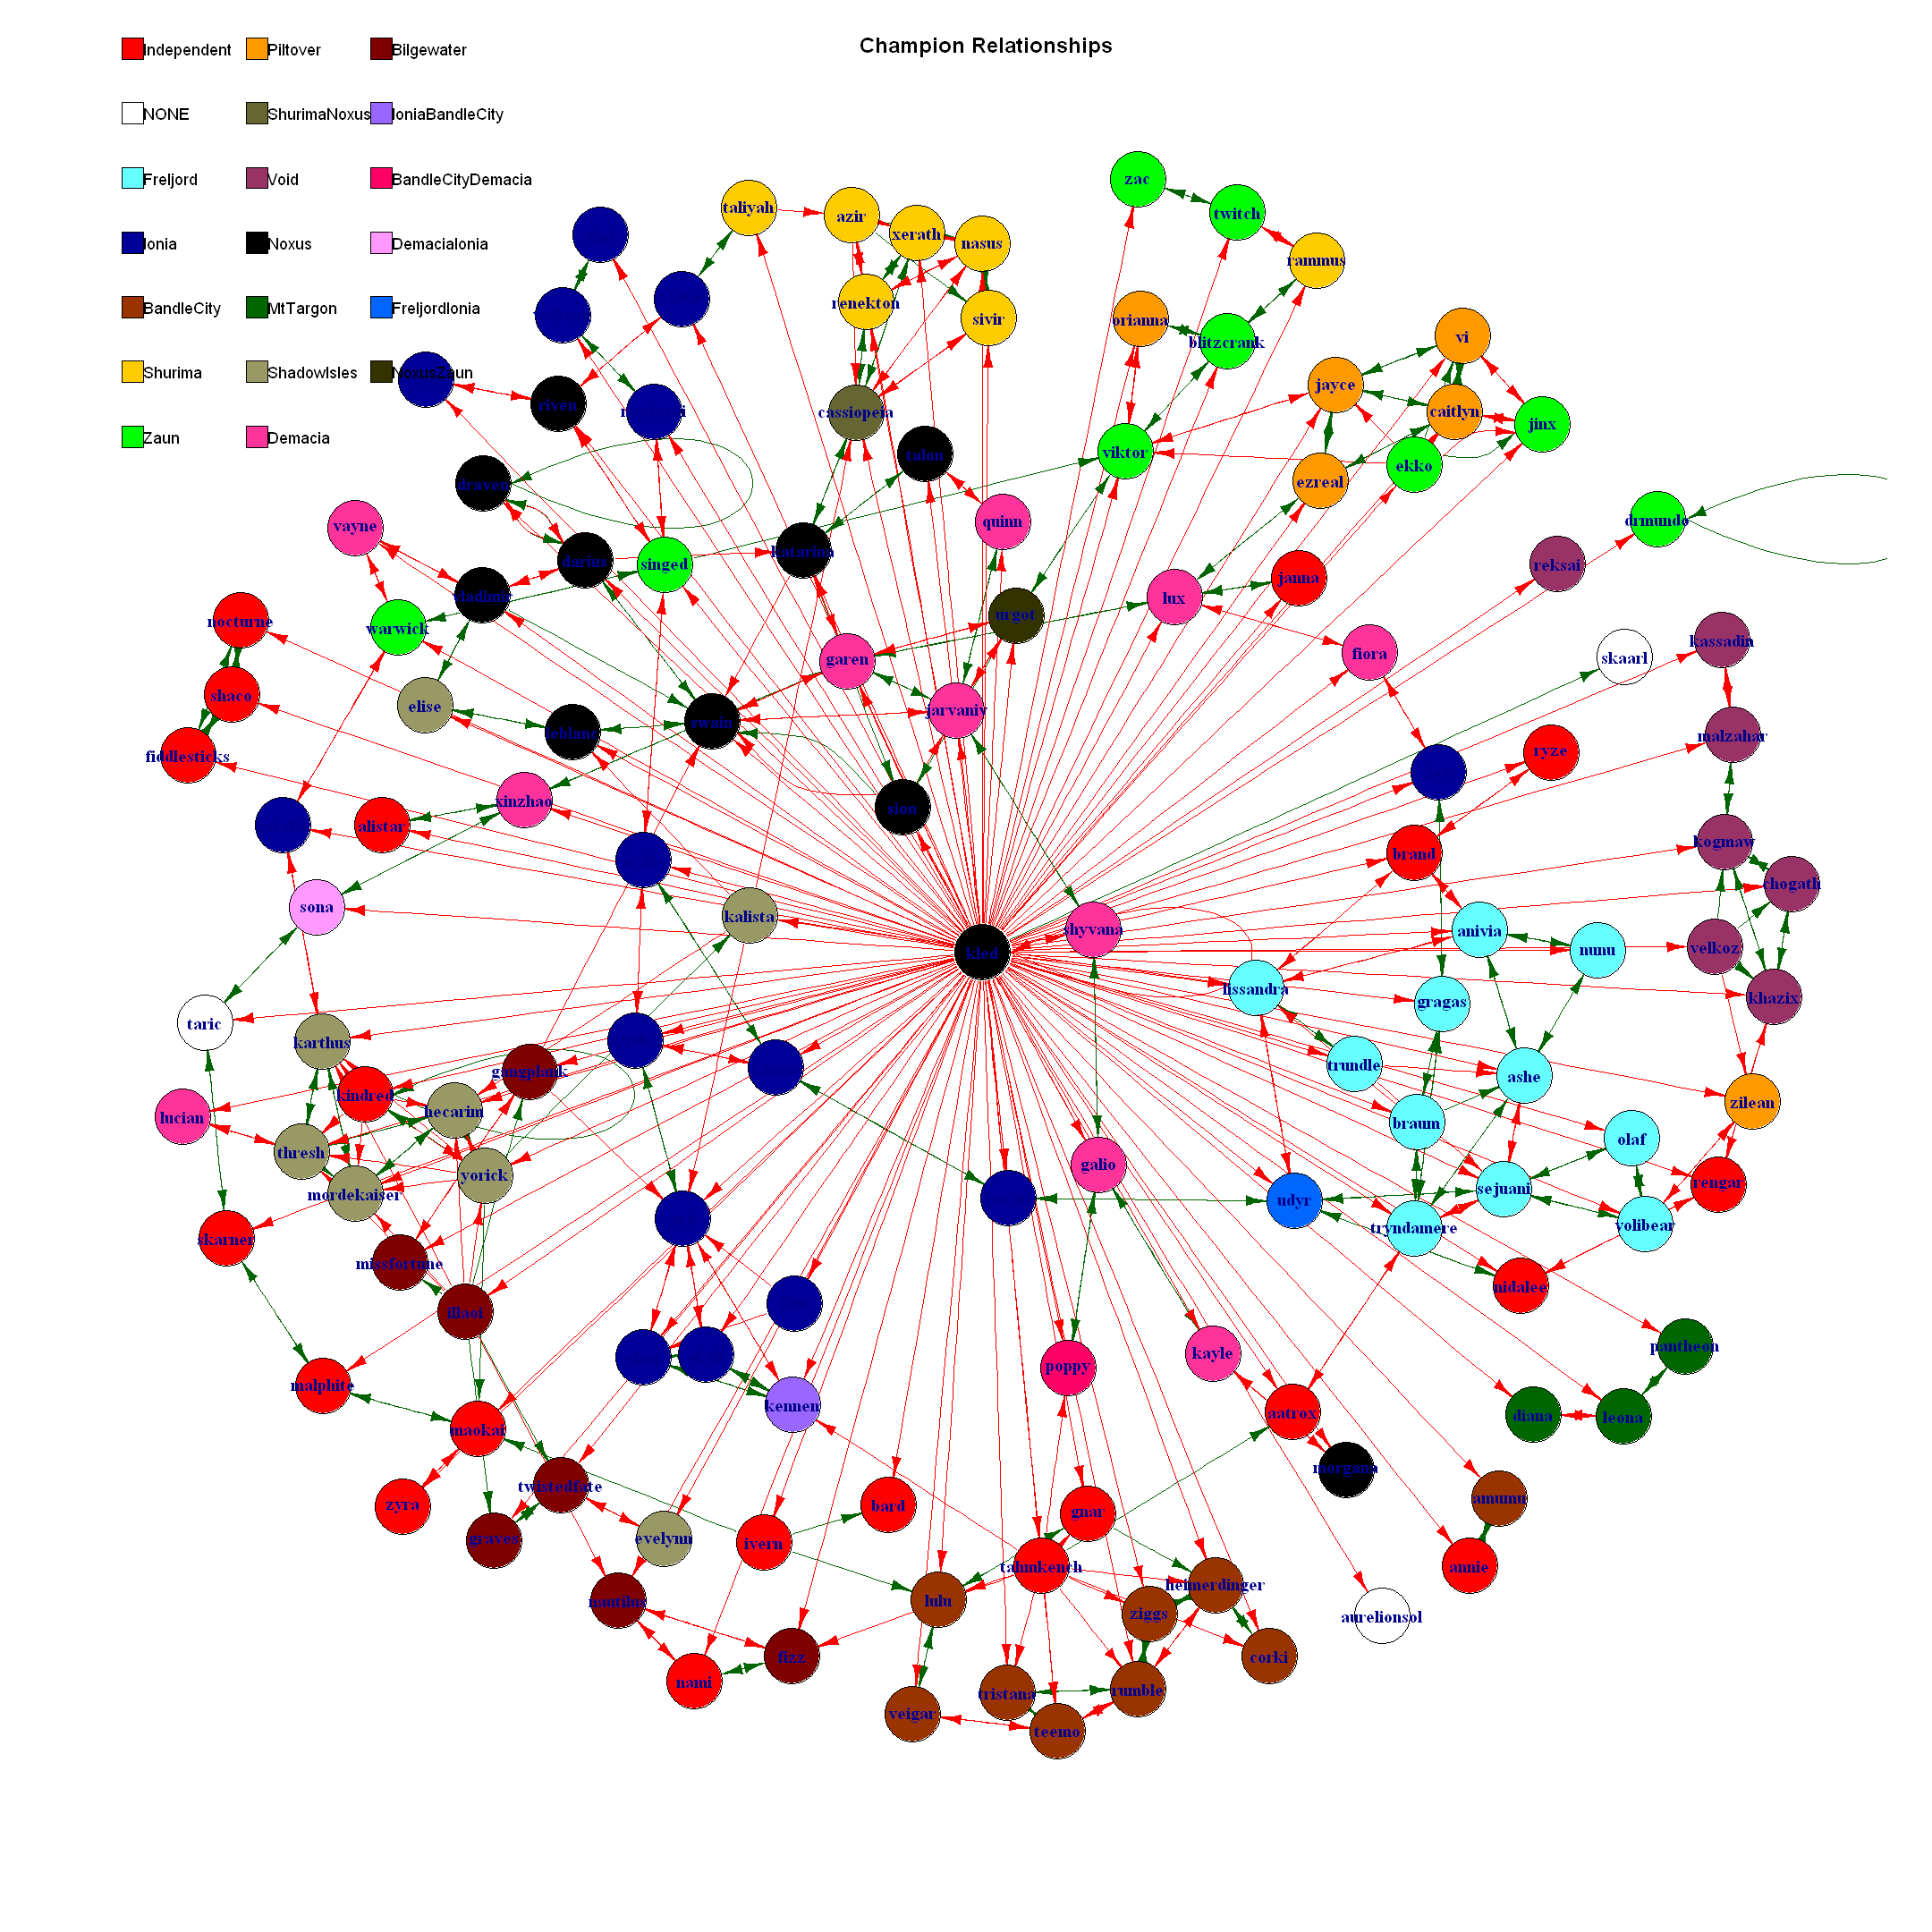

In [187]:
# adding factions to the graph

V(both)$Faction = as.character(edgeFactionTarget[match(V(both)$name, edgeFactionSource)])
head(V(both)$Faction)
allFactions = unique(V(both)$Faction)
allFactions
factionColors <- c('#FF0000',NA,'#66FFFF','#000099','#993300','#FFCC00','#00FF00','#FF9900','#666633','#993366', '#000000','#006600','#999966','#FF3399','#800000','#9966FF','#FF0066','#FF99FF','#0066FF','#333300')
# factionColors <- c('#FF0000',NA,'lightblue','blue','brown','gold','lawngreen','orange',NA,'purple', 'black','darkgreen','darkgray','ivory','darkblue',NA,NA,NA,NA,NA)
# add a key for colors
factionNumber <- function ( faction ) {
  match( faction, allFactions )}
V(both)$color <- factionColors[factionNumber(V(both)$Faction)]

V(both)$size <- vertexSize
V(both)$label.cex <- vLabelSize
V(both)$label.dist <- vLabelDist
V(both)$label.color <- vLabelColor
V(both)$label.font <- vLabelFont
V(both)$label.degree = vLabelDegree
E(both)$arrow.size <- eArrowSize
E(both)$arrow.width <- eArrowWidth

both_layout <- layout.fruchterman.reingold(both, niter=500)

plot(both, layout=both_layout, asp = 0, main = "Champion Relationships")

legend("topleft", text.width=c(.085),
       inset = c(0, -.06), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

#### Friends graph

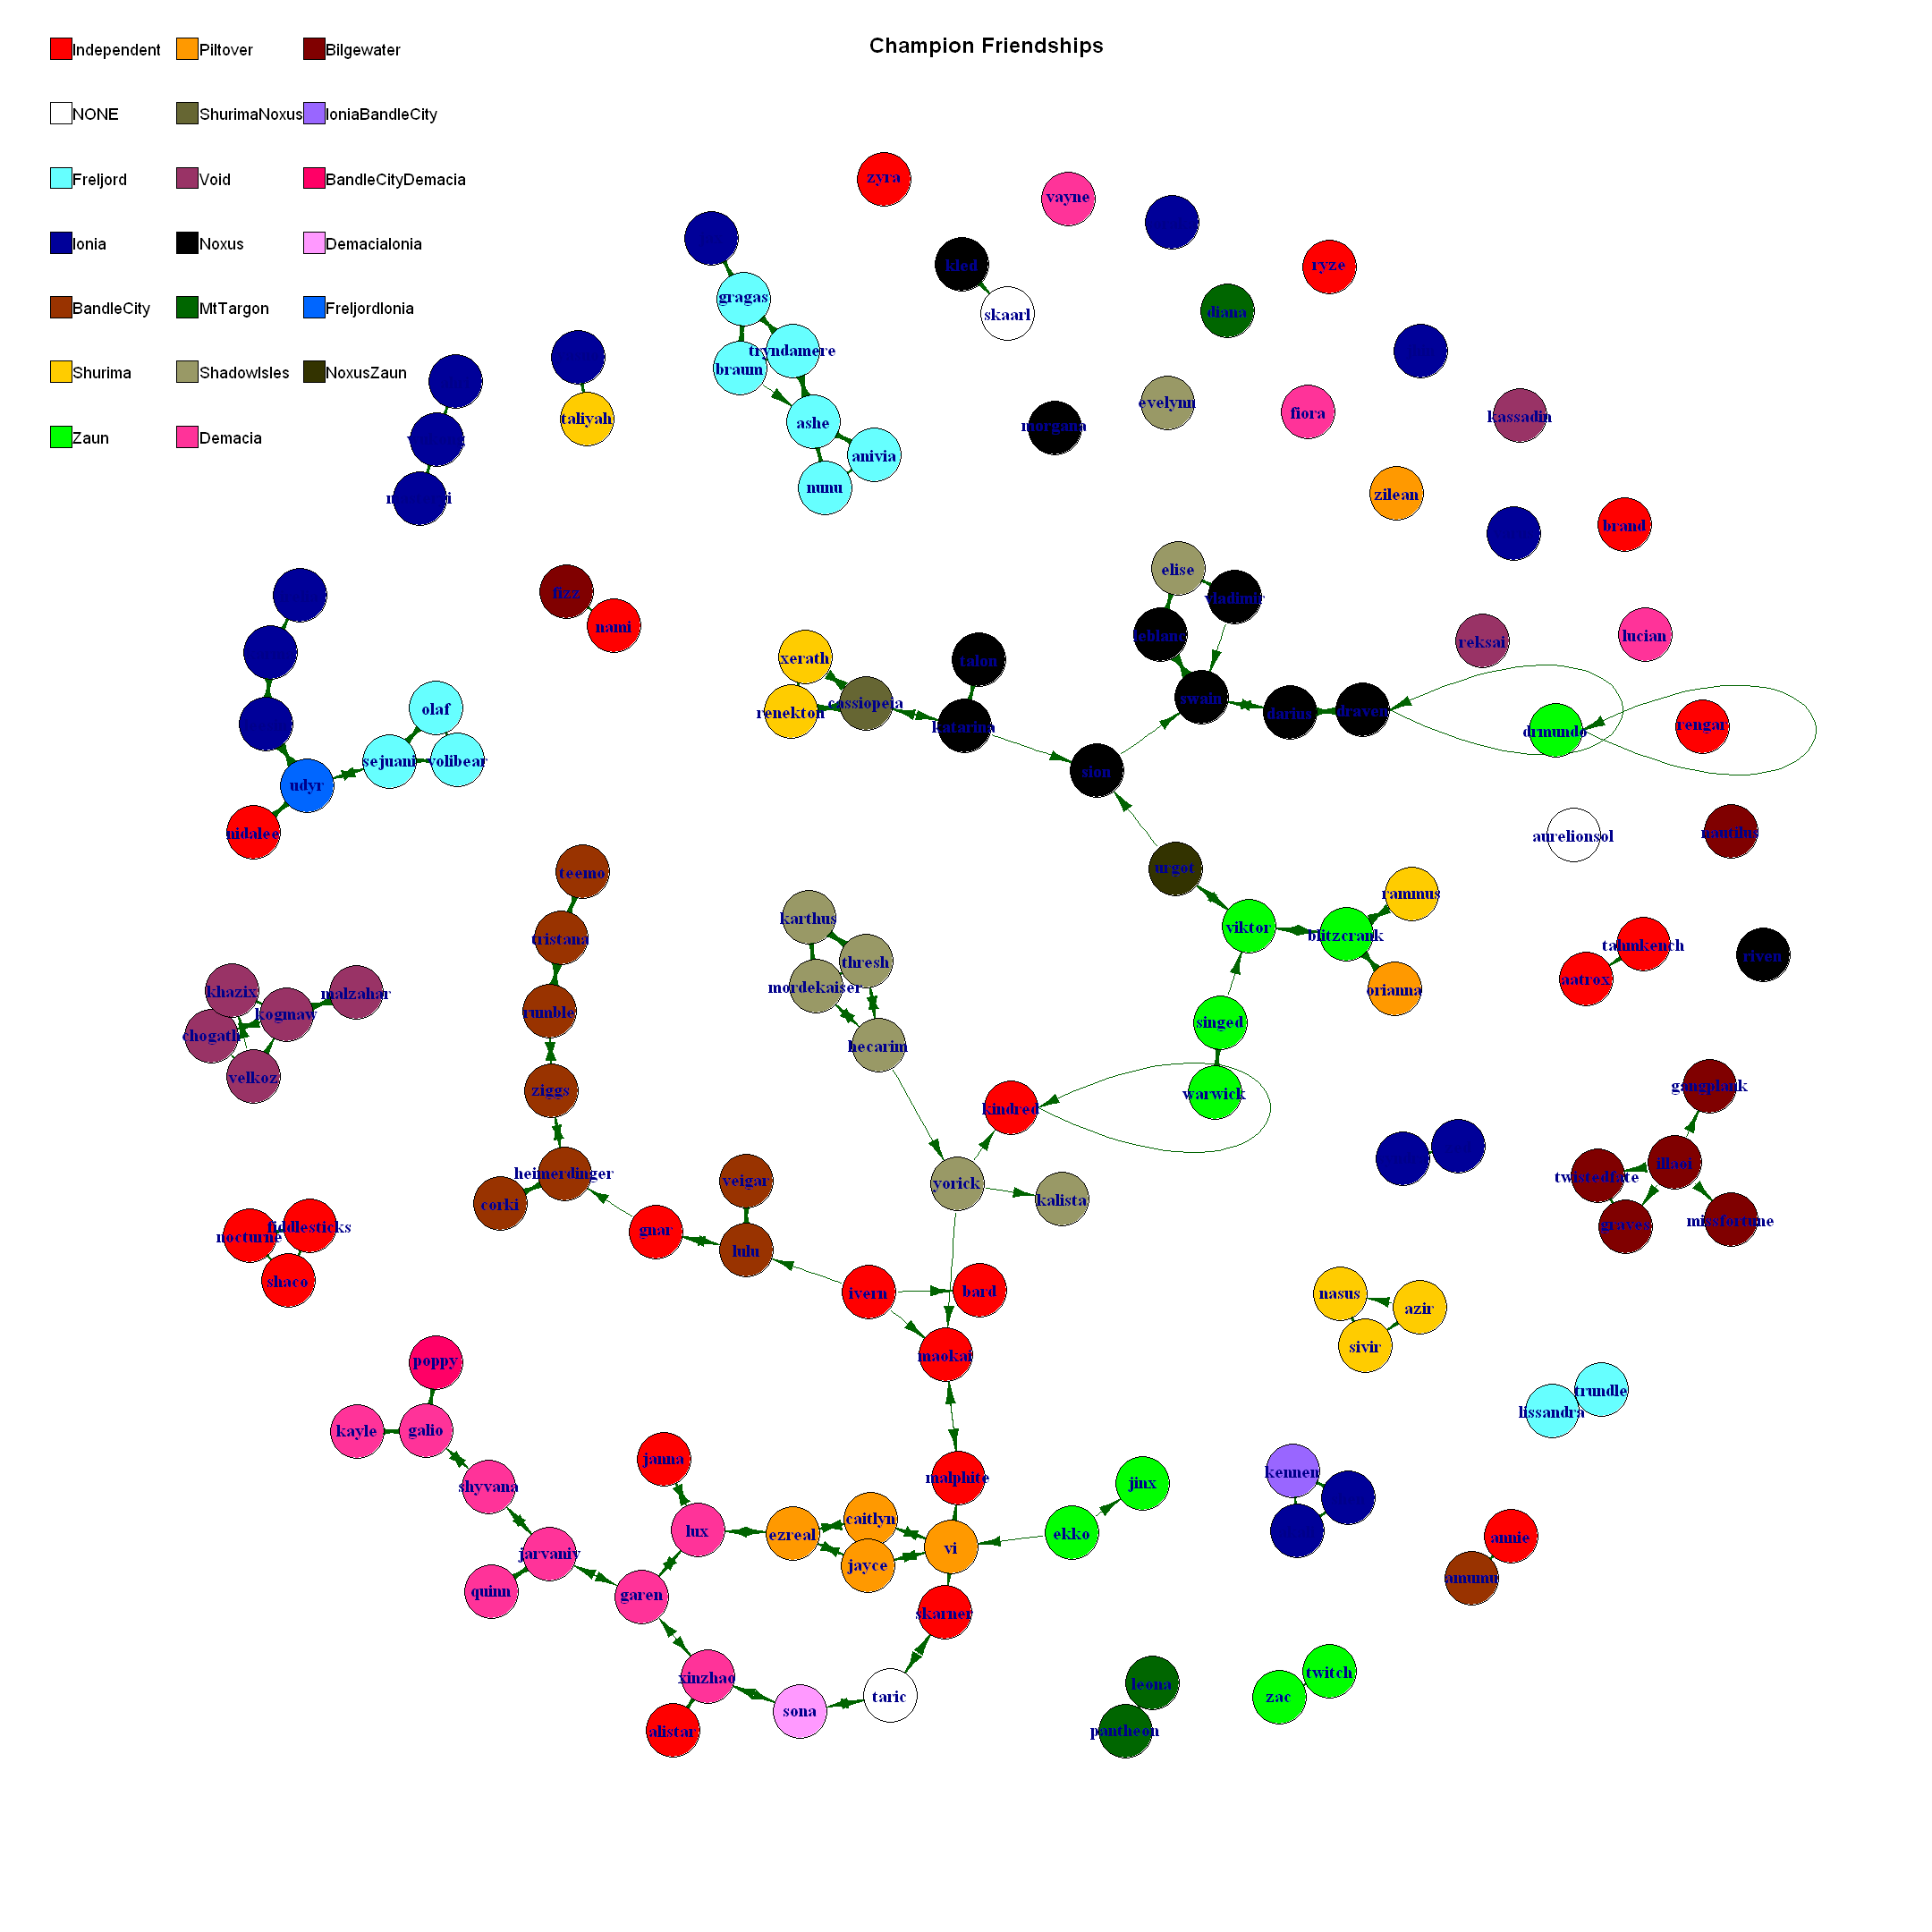

In [188]:
friends <- graph_from_data_frame(d=dfEdge, vertices = dfVertex, direct = T)

E(friends)$color <- "darkgreen" # green for friends
V(friends)$Faction = as.character(edgeFactionTarget[match(V(friends)$name, edgeFactionSource)])

allFactions = unique(V(friends)$Faction)

V(friends)$color <- factionColors[factionNumber(V(friends)$Faction)]
V(friends)$size <- vertexSize
V(friends)$label.cex <- vLabelSize
V(friends)$label.dist <- vLabelDist
V(friends)$label.color <- vLabelColor
V(friends)$label.font <- vLabelFont
V(friends)$label.degree = vLabelDegree
E(friends)$arrow.size <- eArrowSize
E(friends)$arrow.width <- eArrowWidth

plot(friends, main = "Champion Friendships")

legendAllFactions = allFactions
legendAllFactions[2] = "NONE"

legend("topleft", text.width=c(.085),
       inset = c(0, -.06), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

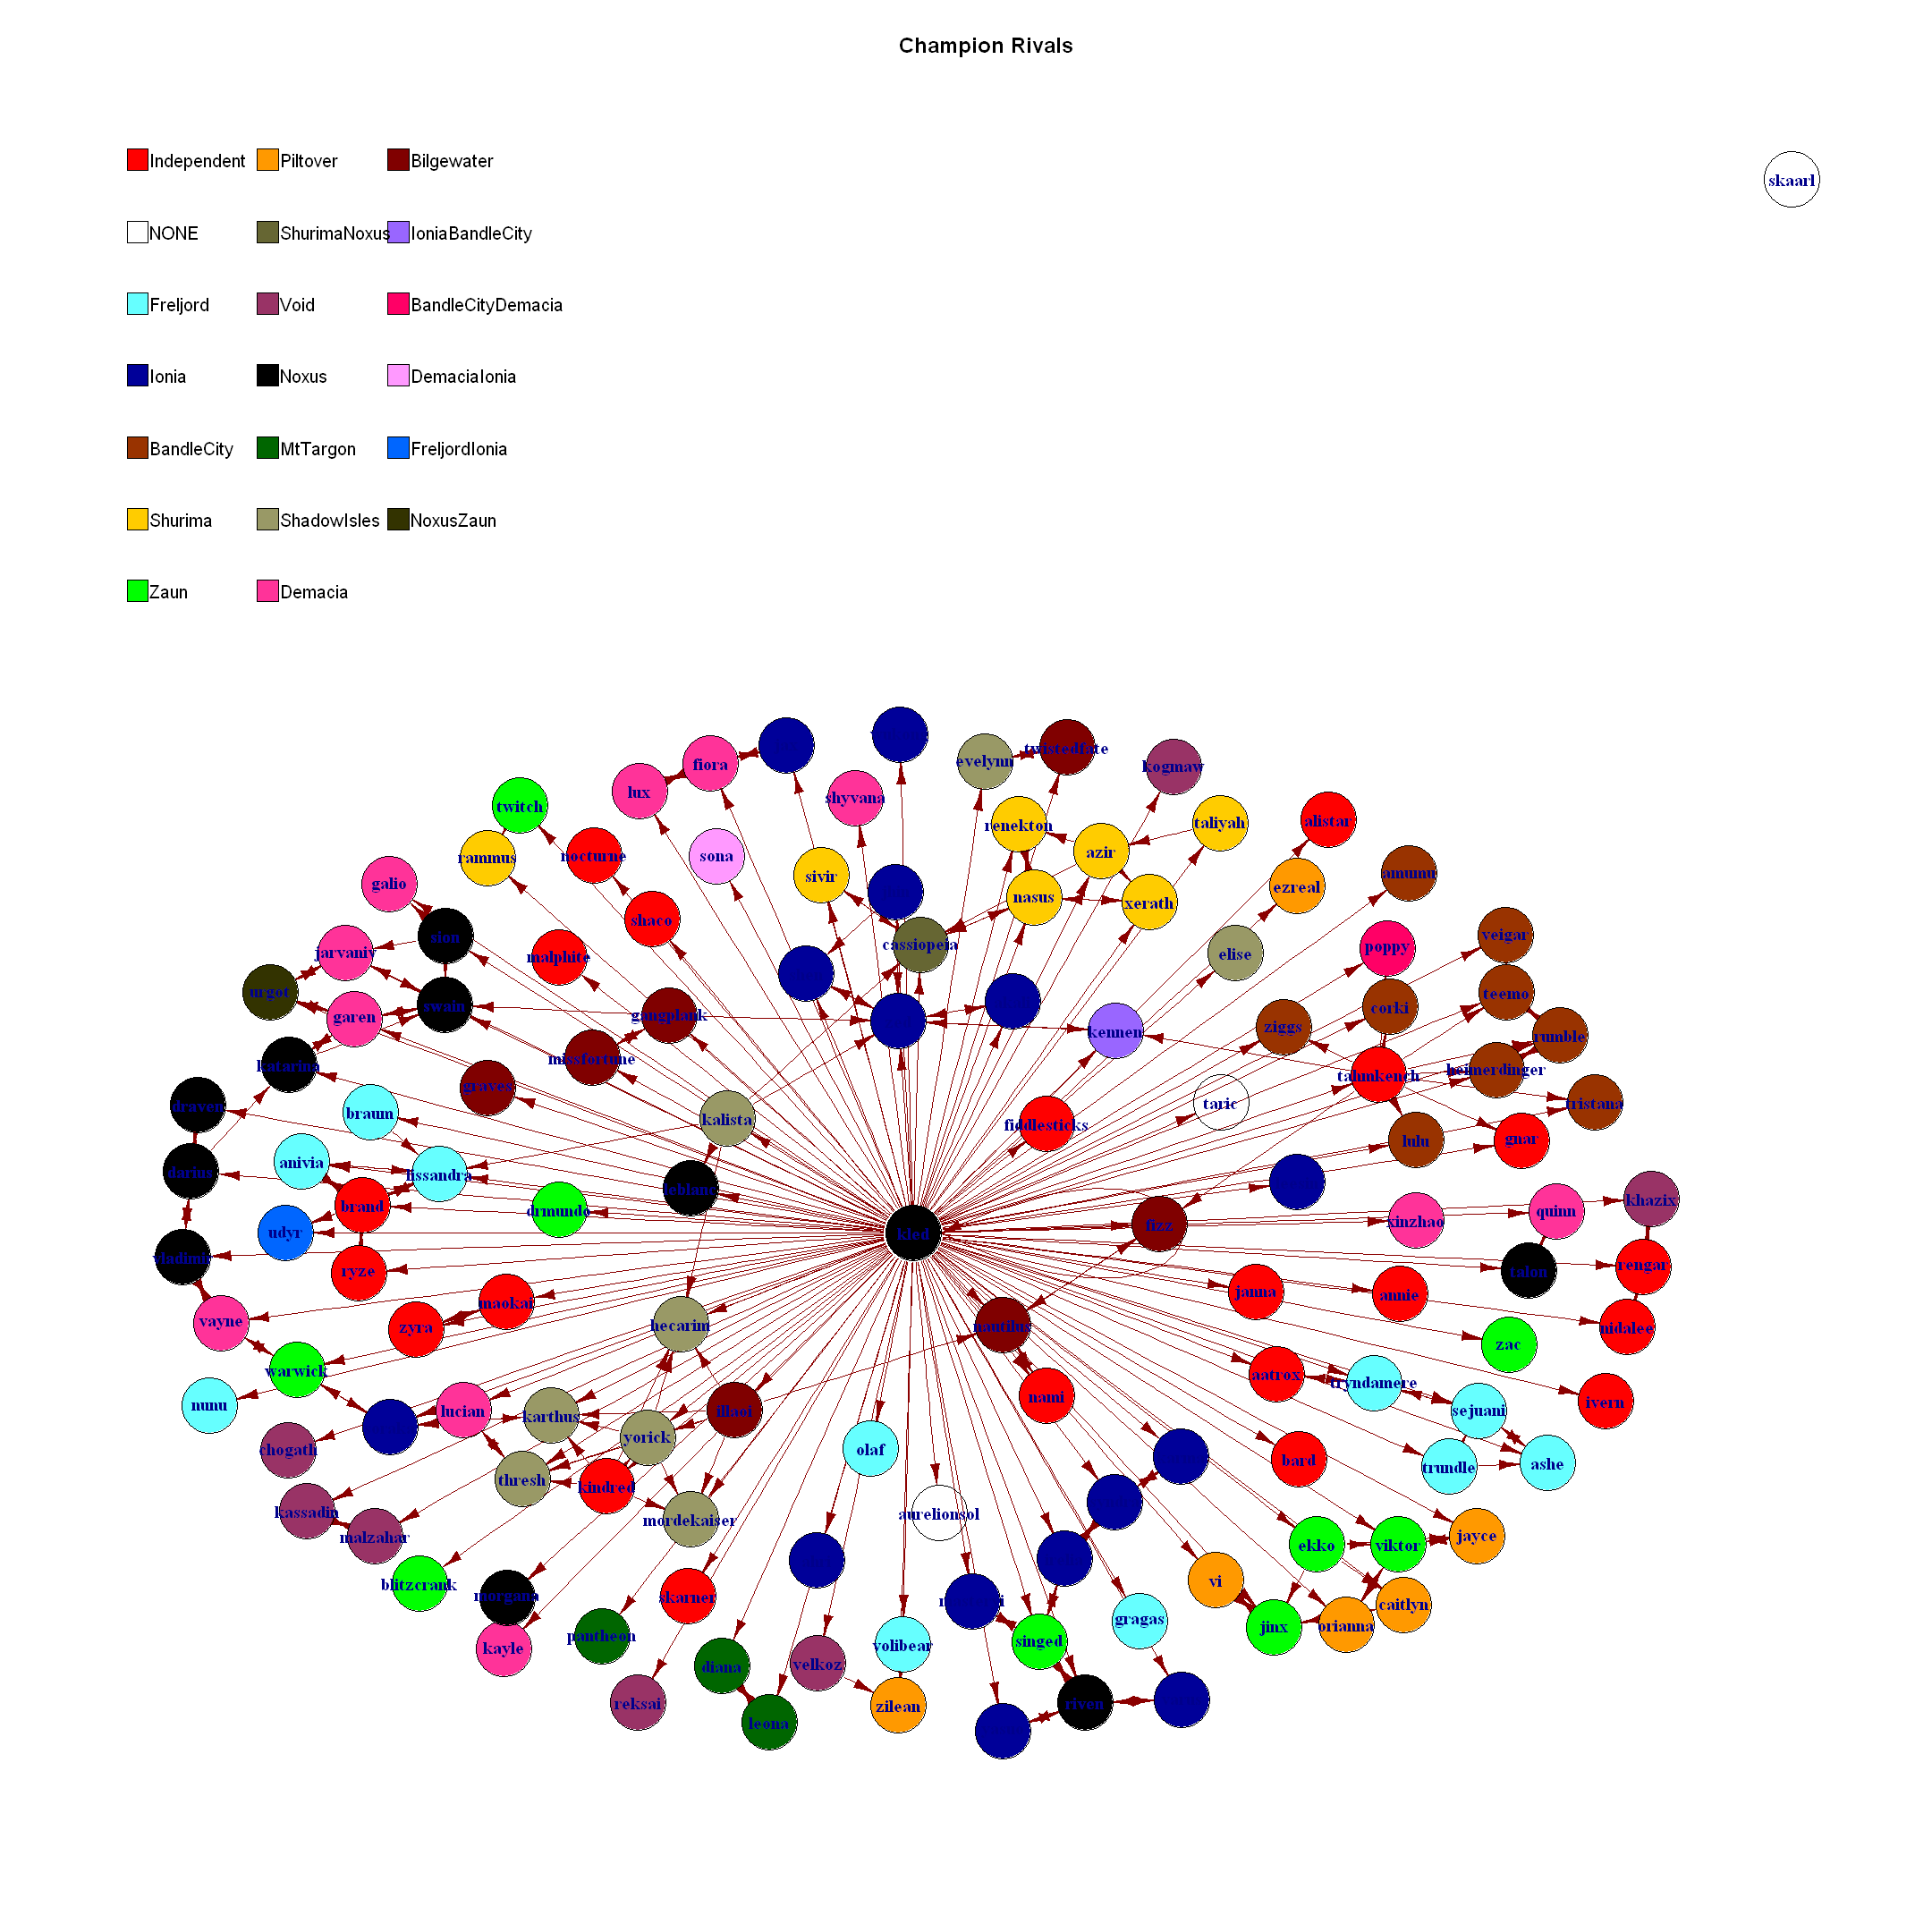

In [189]:
# Rivals graph
rivals <- make_empty_graph() + vertices ( vertexNames)

rivals <- add_edges(rivals, edgeRivals, attr=list(color="red")) #red for enemies
E(rivals)$color <- "darkred" # red for rivals
V(rivals)$Faction = as.character(edgeFactionTarget[match(V(rivals)$name, edgeFactionSource)])

#Factions added!

allFactions = unique(V(rivals)$Faction)

V(rivals)$color <- factionColors[factionNumber(V(rivals)$Faction)]
V(rivals)$size <- vertexSize
V(rivals)$label.cex <- vLabelSize
V(rivals)$label.dist <- vLabelDist
V(rivals)$label.color <- vLabelColor
V(rivals)$label.font <- vLabelFont
V(rivals)$label.degree = vLabelDegree
E(rivals)$arrow.size <- eArrowSize
E(rivals)$arrow.width <- eArrowWidth

l = layout_with_fr(rivals)

plot(rivals, layout=l, asp = 0, main = "Champion Rivals")

legend("topleft", text.width=c(.085),
       inset = c(0, 0), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = 1, xpd = TRUE)

## Graph Calculations

#### Betweenness

```{r}
highest <- max(betweenness(rivals))
index_of_highest <- match(highest, betweenness(rivals))
print(index_of_highest)
rivals[[index_of_highest]]
#darius is the point of highest connection between all rivals

highest <- max(betweenness(friends))
index_of_highest <- match(highest, betweenness(friends))
print(index_of_highest) 
friends[[index_of_highest]] 
#garen between friends

highest <- max(betweenness(both)) 
index_of_highest <- match(highest, betweenness(both)) 
print(index_of_highest) 
both[[index_of_highest]] 
#garen again
```

#### Closeness Least Friends, Rivals, Both

```{r}
closest <- min(closeness(rivals))
index_of_closest <- match(closest, closeness(rivals))
print(index_of_closest)
rivals[[index_of_closest]]
#aurelionsol rivals

closest <- min(closeness(friends))
index_of_closest <- match(closest, closeness(friends))
print(index_of_closest) 
friends[[index_of_closest]] 
#aatrox friends

closest <- min(closeness(both)) 
index_of_closest <- match(closest, closeness(both)) 
print(index_of_closest) 
both[[index_of_closest]] 
#aurelionsol again
```

#### Closeness Most Friends, Rivals, Both

```{r}
most <- max(closeness(rivals))
index_of_most <- match(most, closeness(rivals))
print(index_of_most)
rivals[[index_of_most]]
#kled most rivals

most <- max(closeness(friends))
index_of_most <- match(most, closeness(friends))
print(index_of_most) 
friends[[index_of_most]] 
#ivern friends (3)

most <- max(closeness(both)) 
index_of_most <- match(most, closeness(both)) 
print(index_of_most) 
both[[index_of_most]] 
#kled again
```


#### Eigenvector Centrality, most influential vertex

```{r}
# set.seed(2)
# #errorszzzzzzzzz randomlly
# influential <- max(evcent(rivals)$vector)
# index_of_influential <- match(influential, evcent(rivals)$vector)
# print(index_of_influential)
# rivals[[index_of_influential]]
# #kled most rivals
# 
# influential <- max(evcent(friends)$vector)
# index_of_influential <- match(influential, evcent(friends)$vector)
# print(index_of_influential)
# friends[[index_of_influential]]
# #ivern friends (3)
# 
# most <- max(evcent(both)$vector)
# index_of_influential <- match(influential, evcent(both)$vector)
# print(index_of_influential)
# both[[index_of_influential]]
# #kled again
```

#### Images in Graph

In [190]:
imgname <- list()
imgfilename <- list()
for (x in 1:134)
    {
    imgname = c(imgname, paste(vertexNames[x], ".png", sep =""))
    imgfilename <- c(imgfilename, file.path(path_to_files,imgname[[x]]))
    }

#### Rivals Image Graph

Warning message in FUN(X[[i]], ...):
"libpng warning: iCCP: known incorrect sRGB profile"

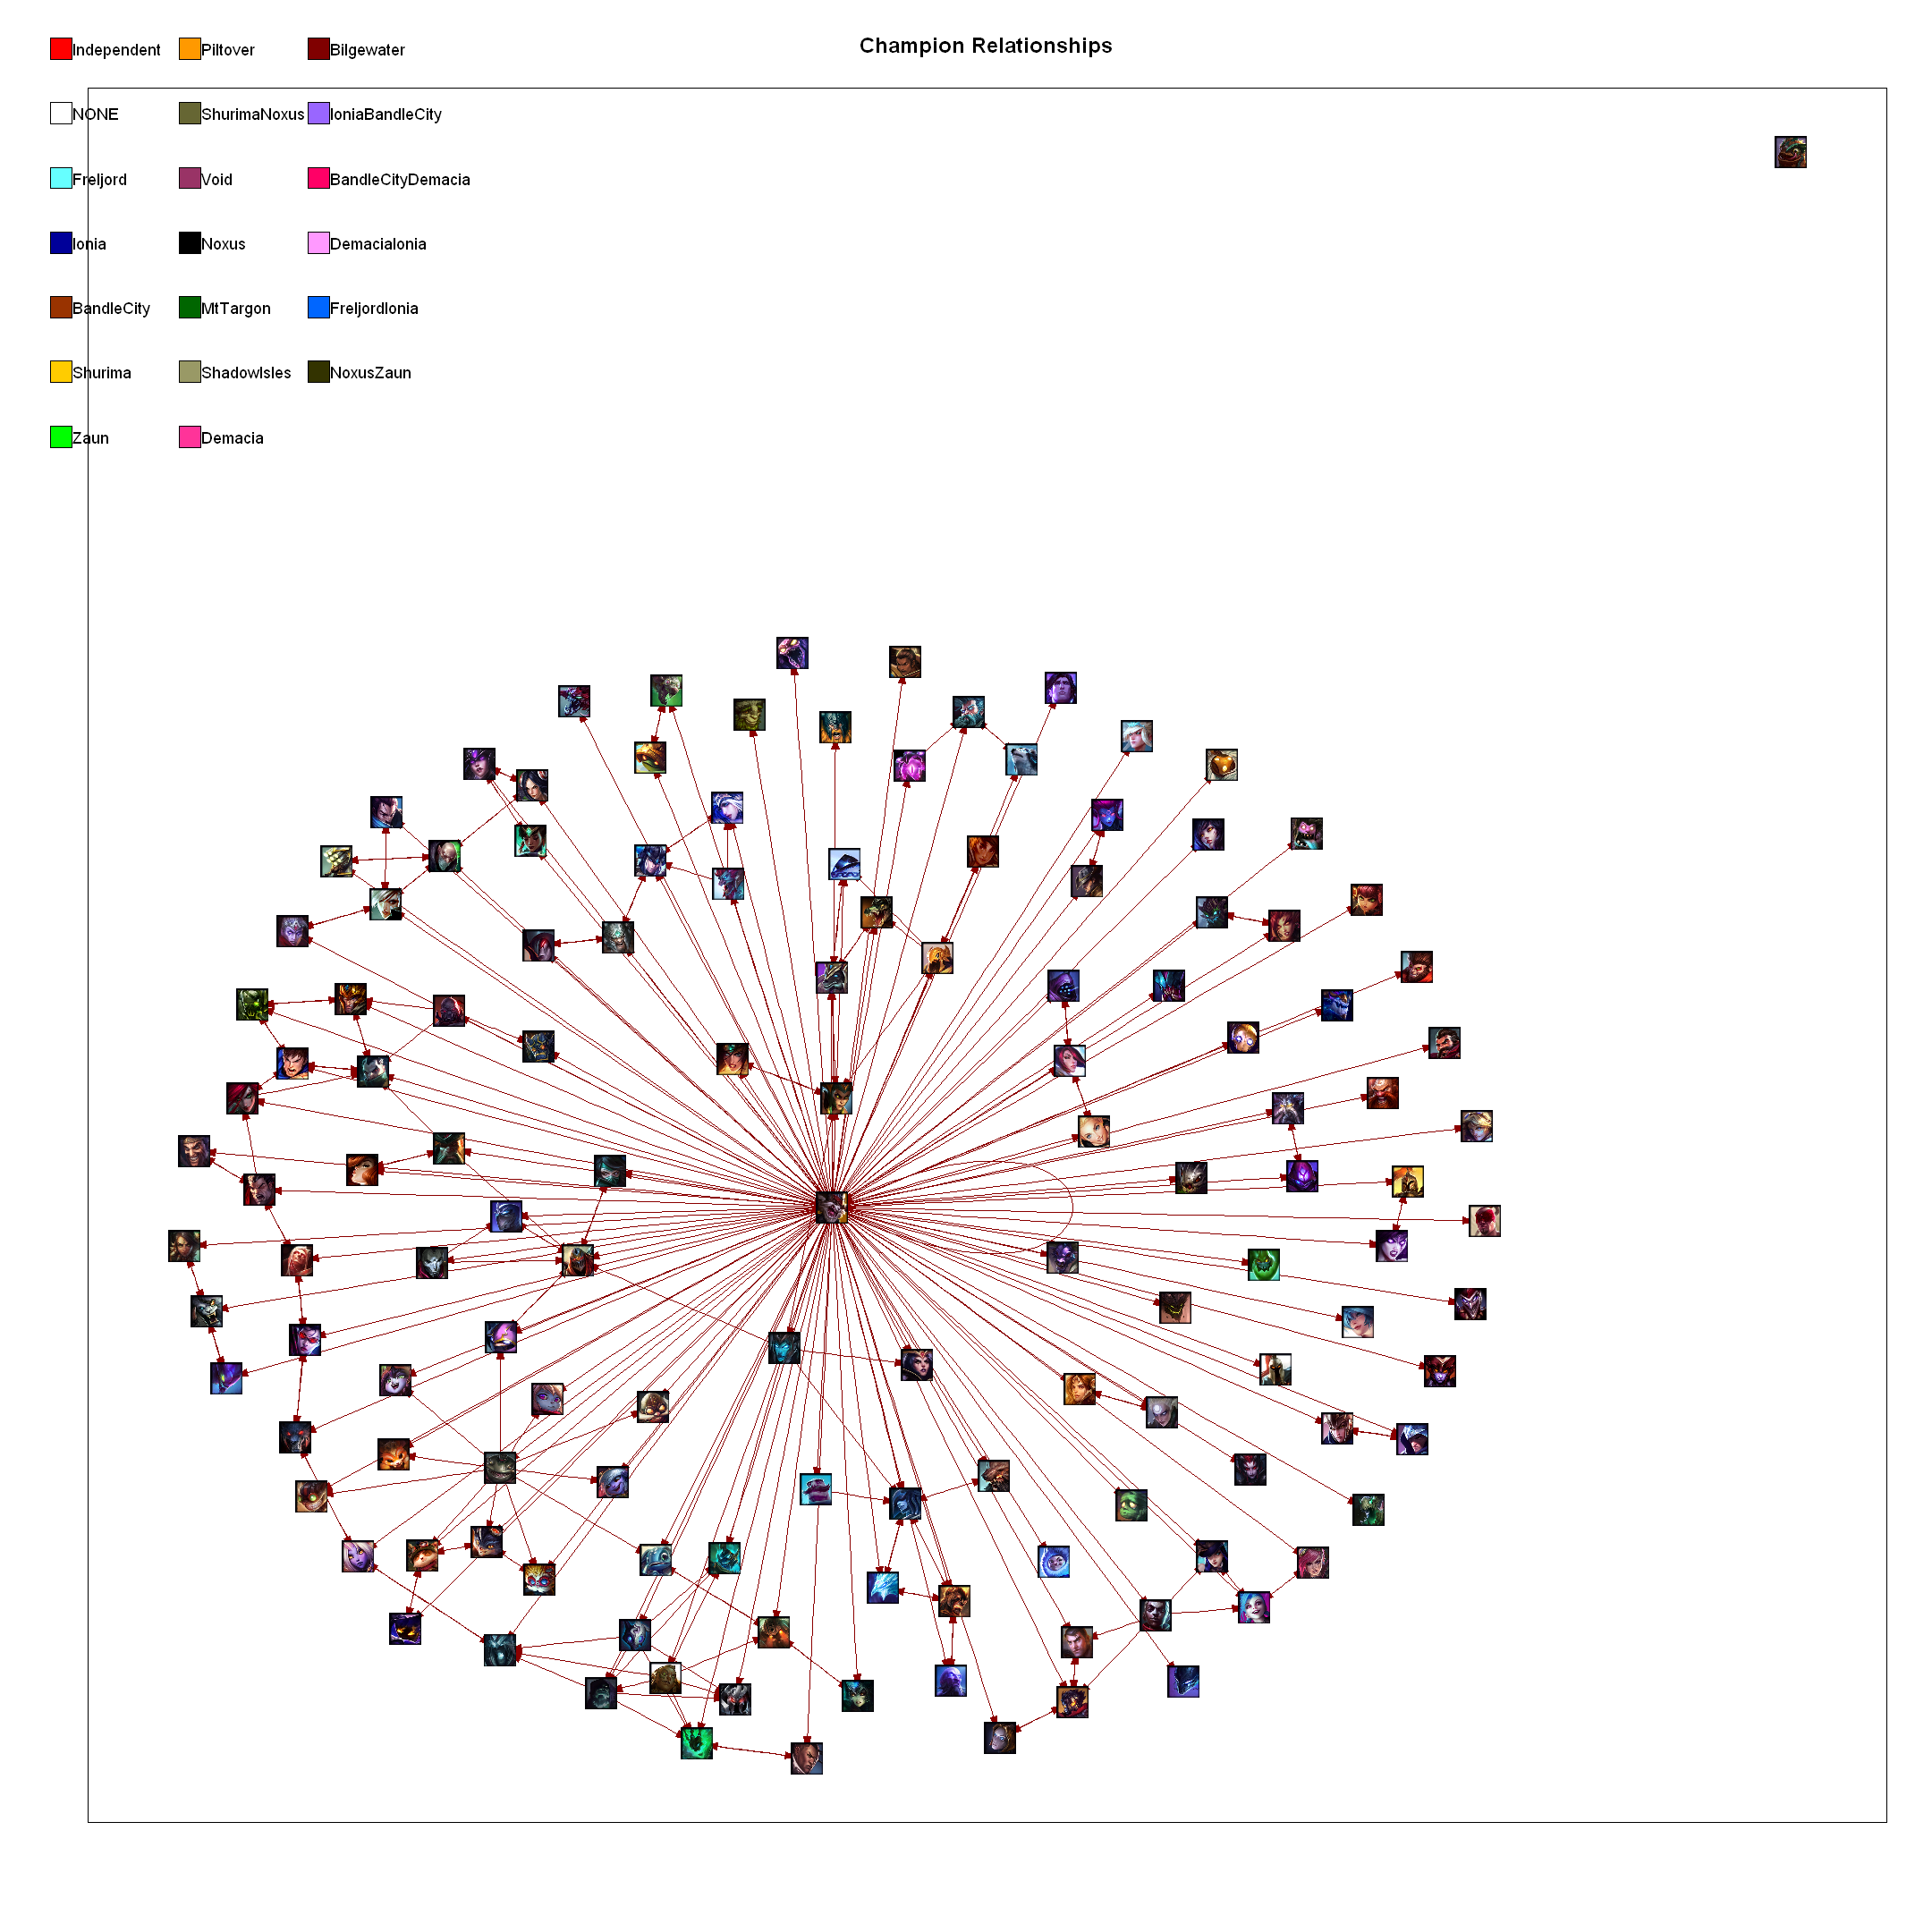

In [191]:
set.seed(1)
# arrows point to x is friends with
l <- layout.norm(layout.fruchterman.reingold(rivals, niter = 500))


V(rivals)$label.cex <- .01
E(rivals)$arrow.size <- .3
E(rivals)$arrow.width <- .5
V(rivals)$size <- .01
V(rivals)$shape <- "square"

options(repr.plot.width=18, repr.plot.height=18)

plot(rivals, layout = l, frame = TRUE, main = "Champion Relationships")

img <- lapply(imgfilename, png::readPNG)

for(i in 1:nrow(l)) {  
  rasterImage(img[[i]], l[i, 1]-0.02, l[i, 2]-0.02, l[i, 1]+0.02, l[i, 2]+0.02)
}

legend("topleft", text.width=c(.085),
       inset = c(0, -.06), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

#### Both Image Graph

Warning message in FUN(X[[i]], ...):
"libpng warning: iCCP: known incorrect sRGB profile"

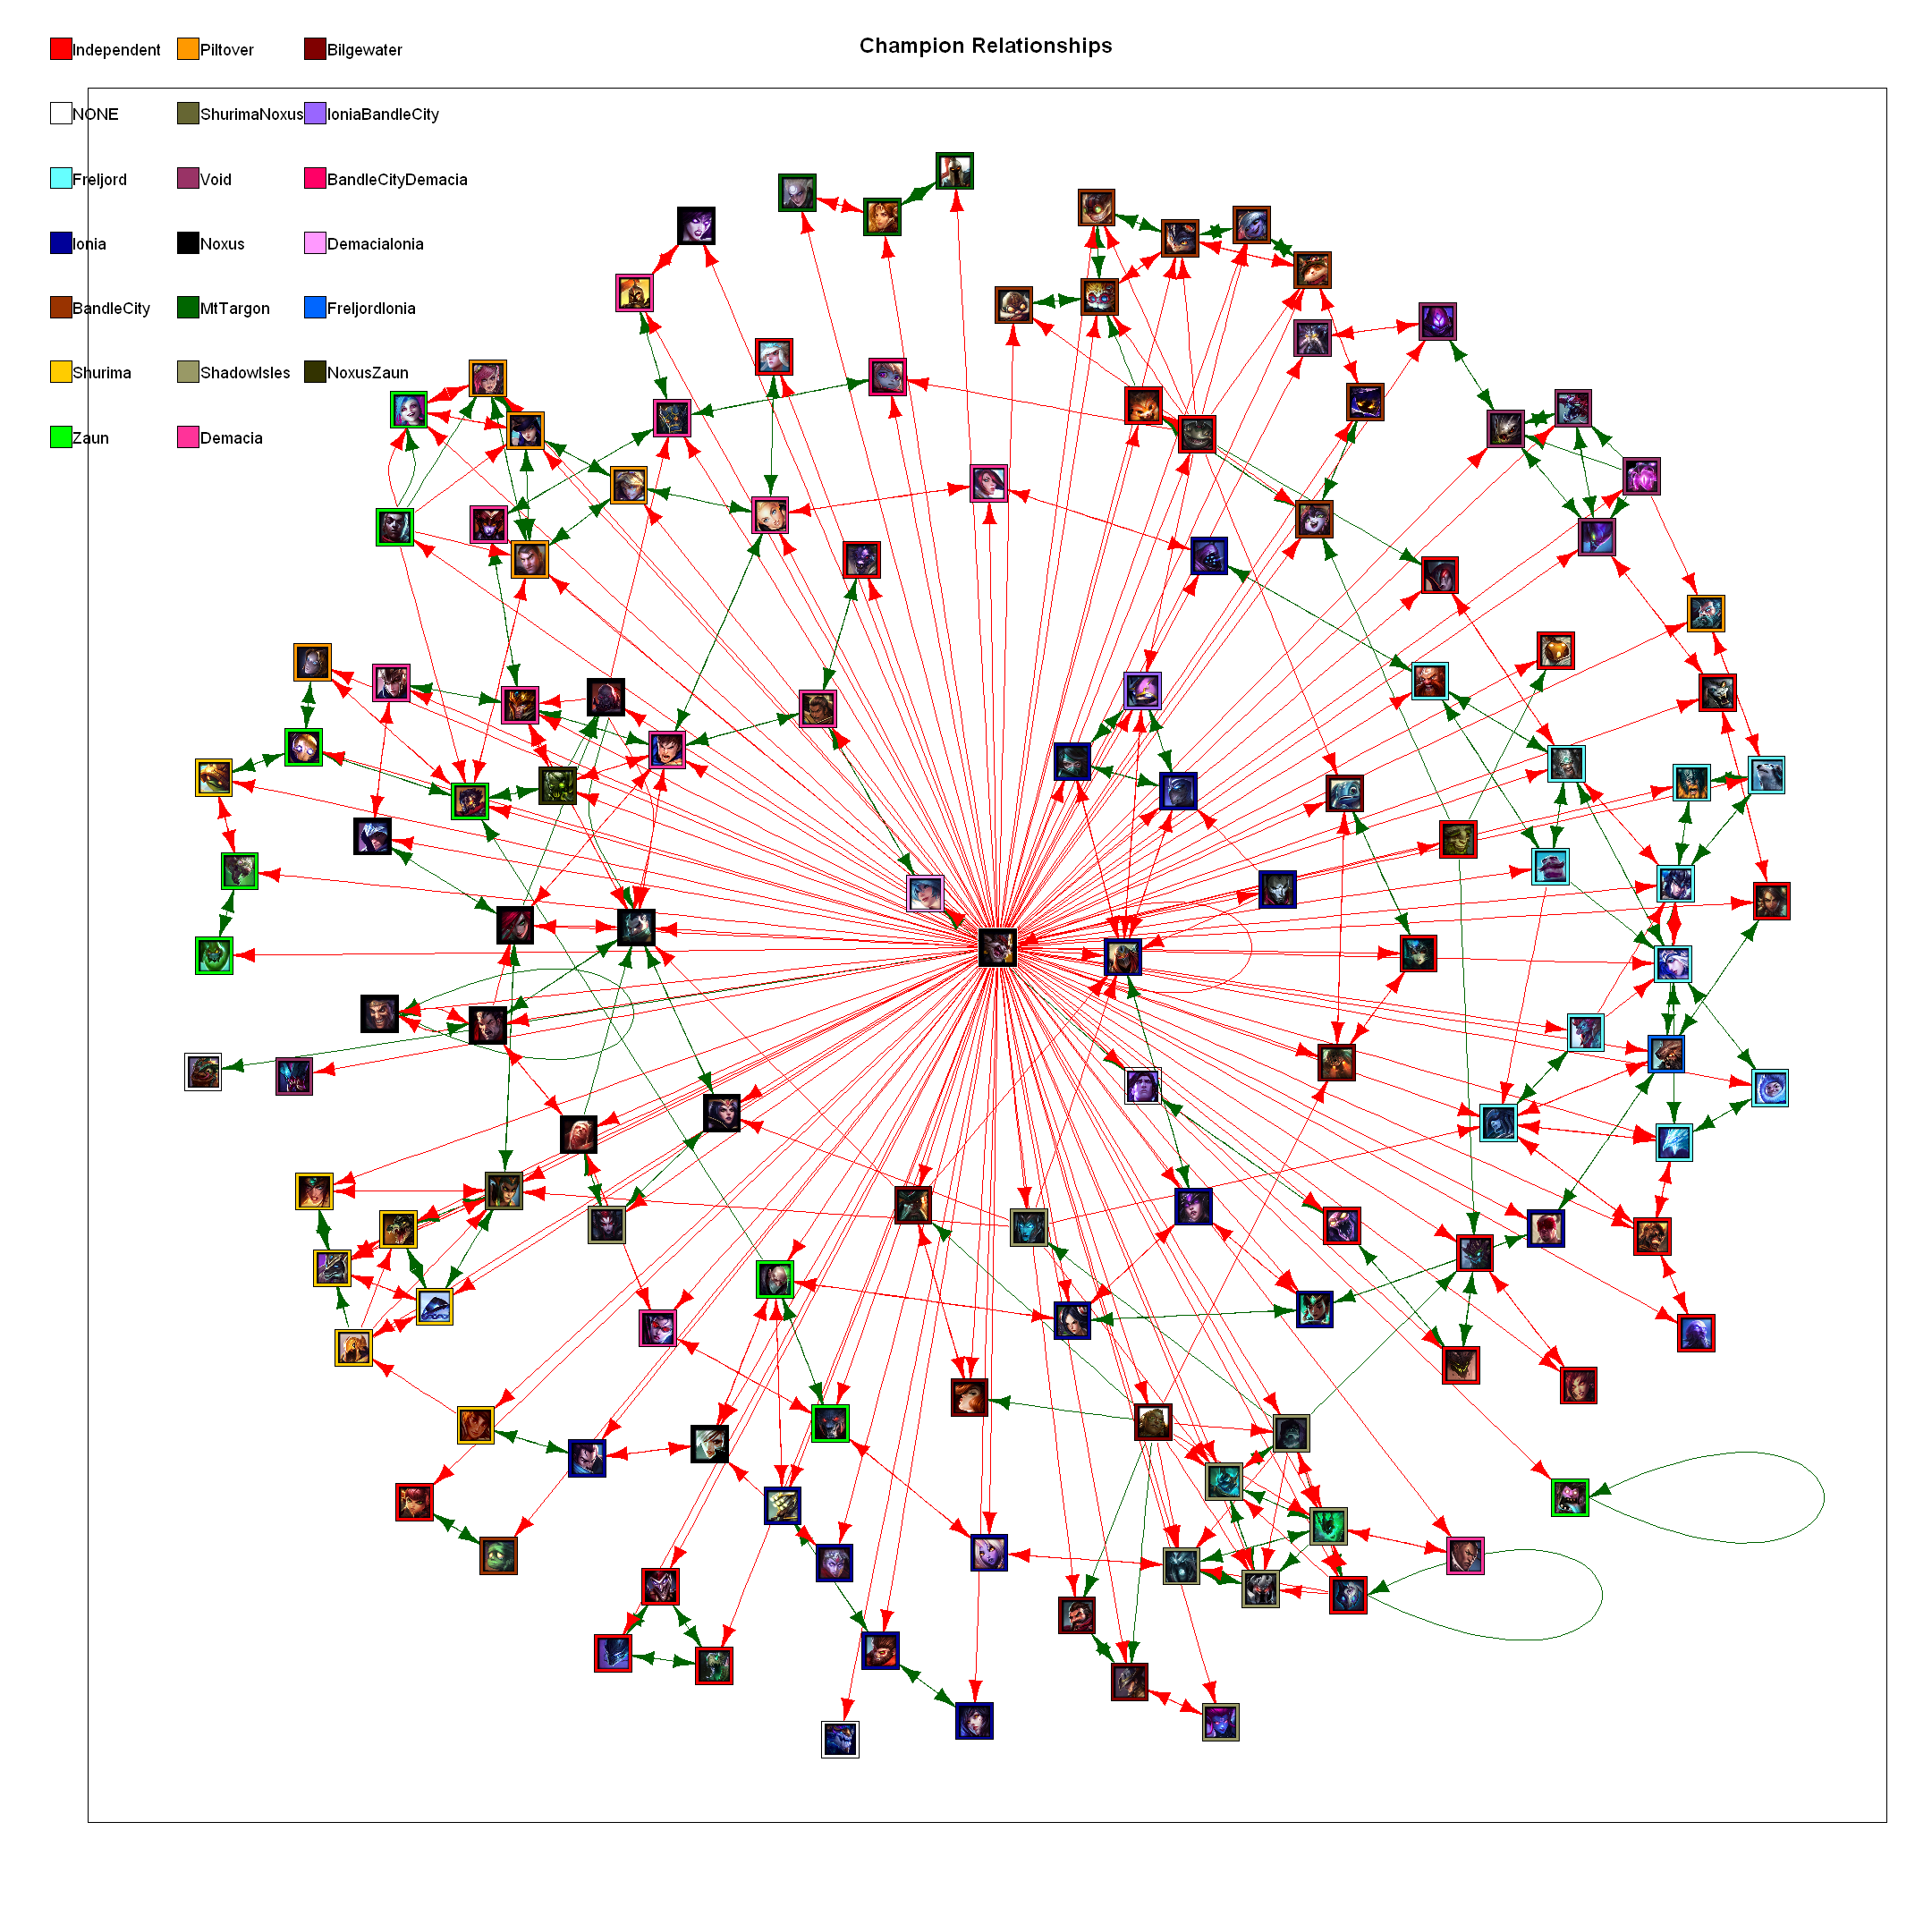

In [192]:
set.seed(1)

l <- layout.norm(layout.fruchterman.reingold(both, niter = 500))

V(both)$label.cex <- .01
V(both)$size <- .008
E(both)$arrow.size <- .3
E(both)$arrow.width <- 1
V(both)$size <- 4.75
V(both)$shape <- "square"

options(repr.plot.width=18, repr.plot.height=18)

plot(both, layout = l, frame = TRUE, main = "Champion Relationships")

img <- lapply(imgfilename, png::readPNG)

for(i in 1:nrow(l)) {  
  rasterImage(img[[i]], l[i, 1]-0.02, l[i, 2]-0.02, l[i, 1]+0.02, l[i, 2]+0.02)
}

legend("topleft", text.width=c(.085),
       inset = c(0, -.06), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

#### Friends Image Graph

Warning message in FUN(X[[i]], ...):
"libpng warning: iCCP: known incorrect sRGB profile"

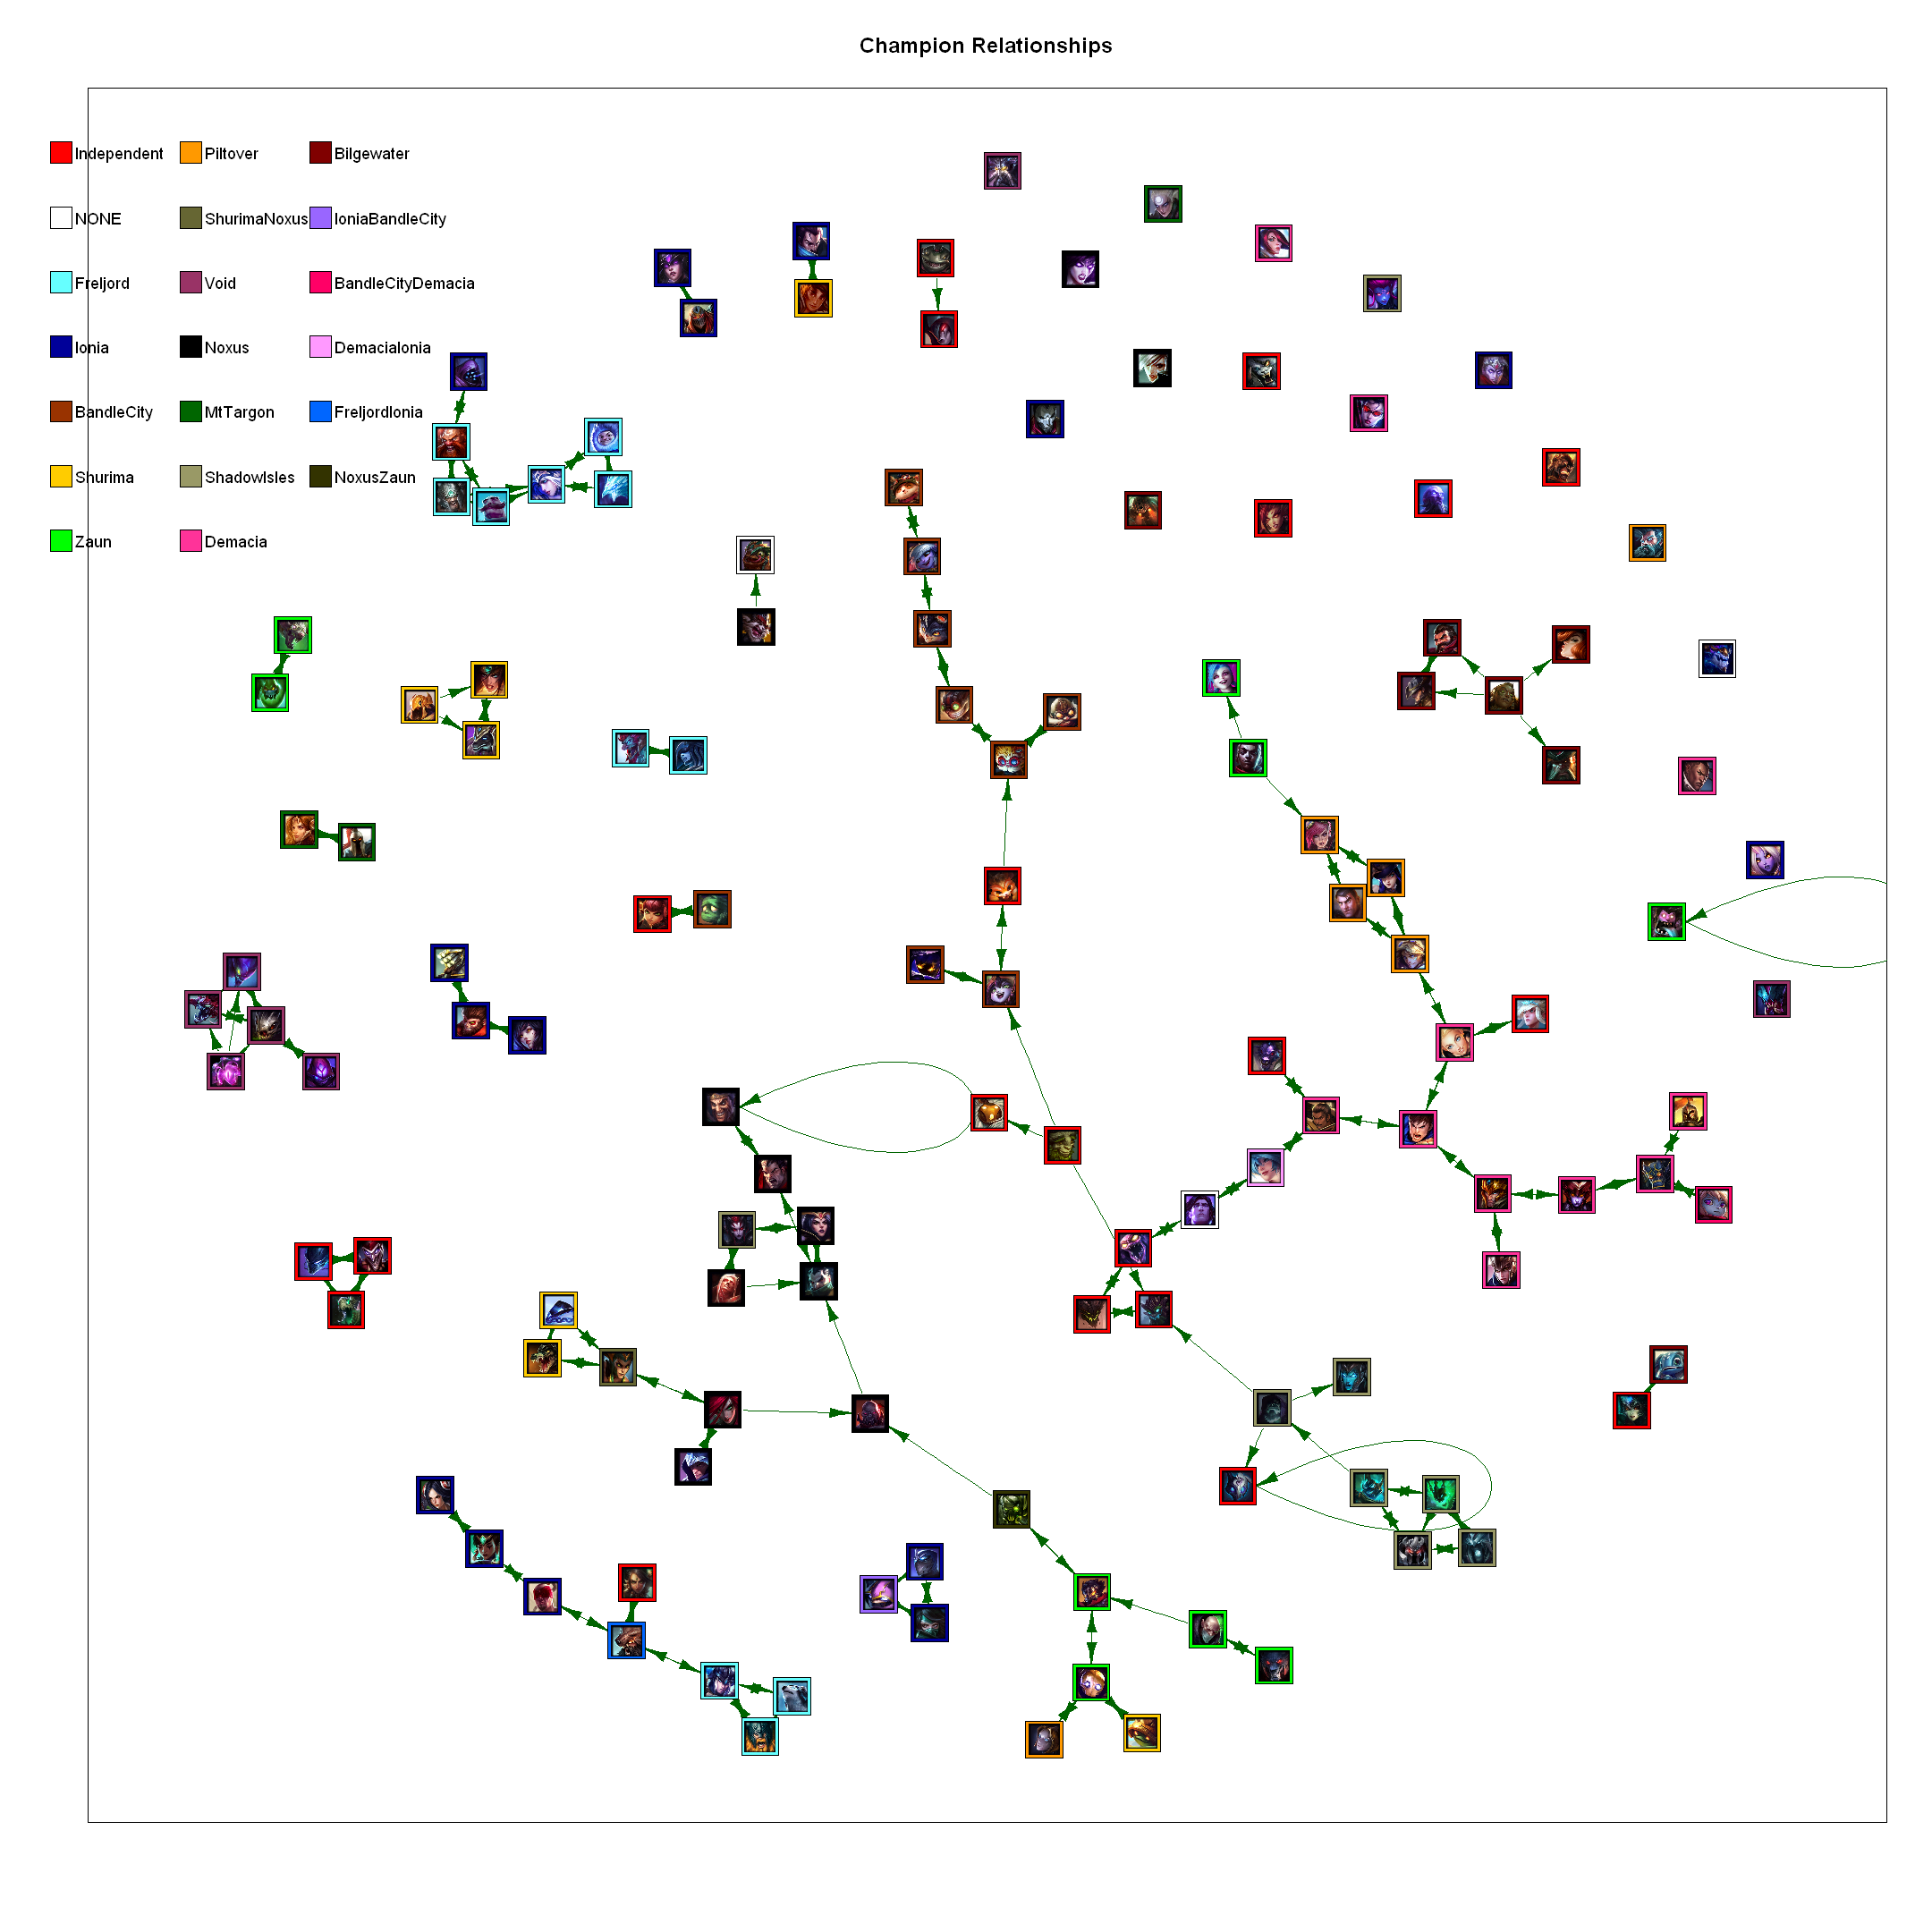

In [193]:
set.seed(1)
# arrows point to x is friends with
l <- layout.norm(layout_with_fr(friends, niter = 500, start.temp = 20 ))

V(friends)$label.cex <- .01
V(friends)$size <- 4.75
V(friends)$shape <- "square"
E(friends)$arrow.size <- .3

plot(friends, layout = l, frame = TRUE, main = "Champion Relationships")

img <- lapply(imgfilename, png::readPNG)

for(i in 1:nrow(l)) {  
  rasterImage(img[[i]], l[i, 1]-0.02, l[i, 2]-0.02, l[i, 1]+0.02, l[i, 2]+0.02)
}

legend("topleft", text.width=c(.085),
       inset = c(0, 0), bty = "n", x.intersp=.3,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

#### Rivals No Kled Image Graph

Warning message in FUN(X[[i]], ...):
"libpng warning: iCCP: known incorrect sRGB profile"

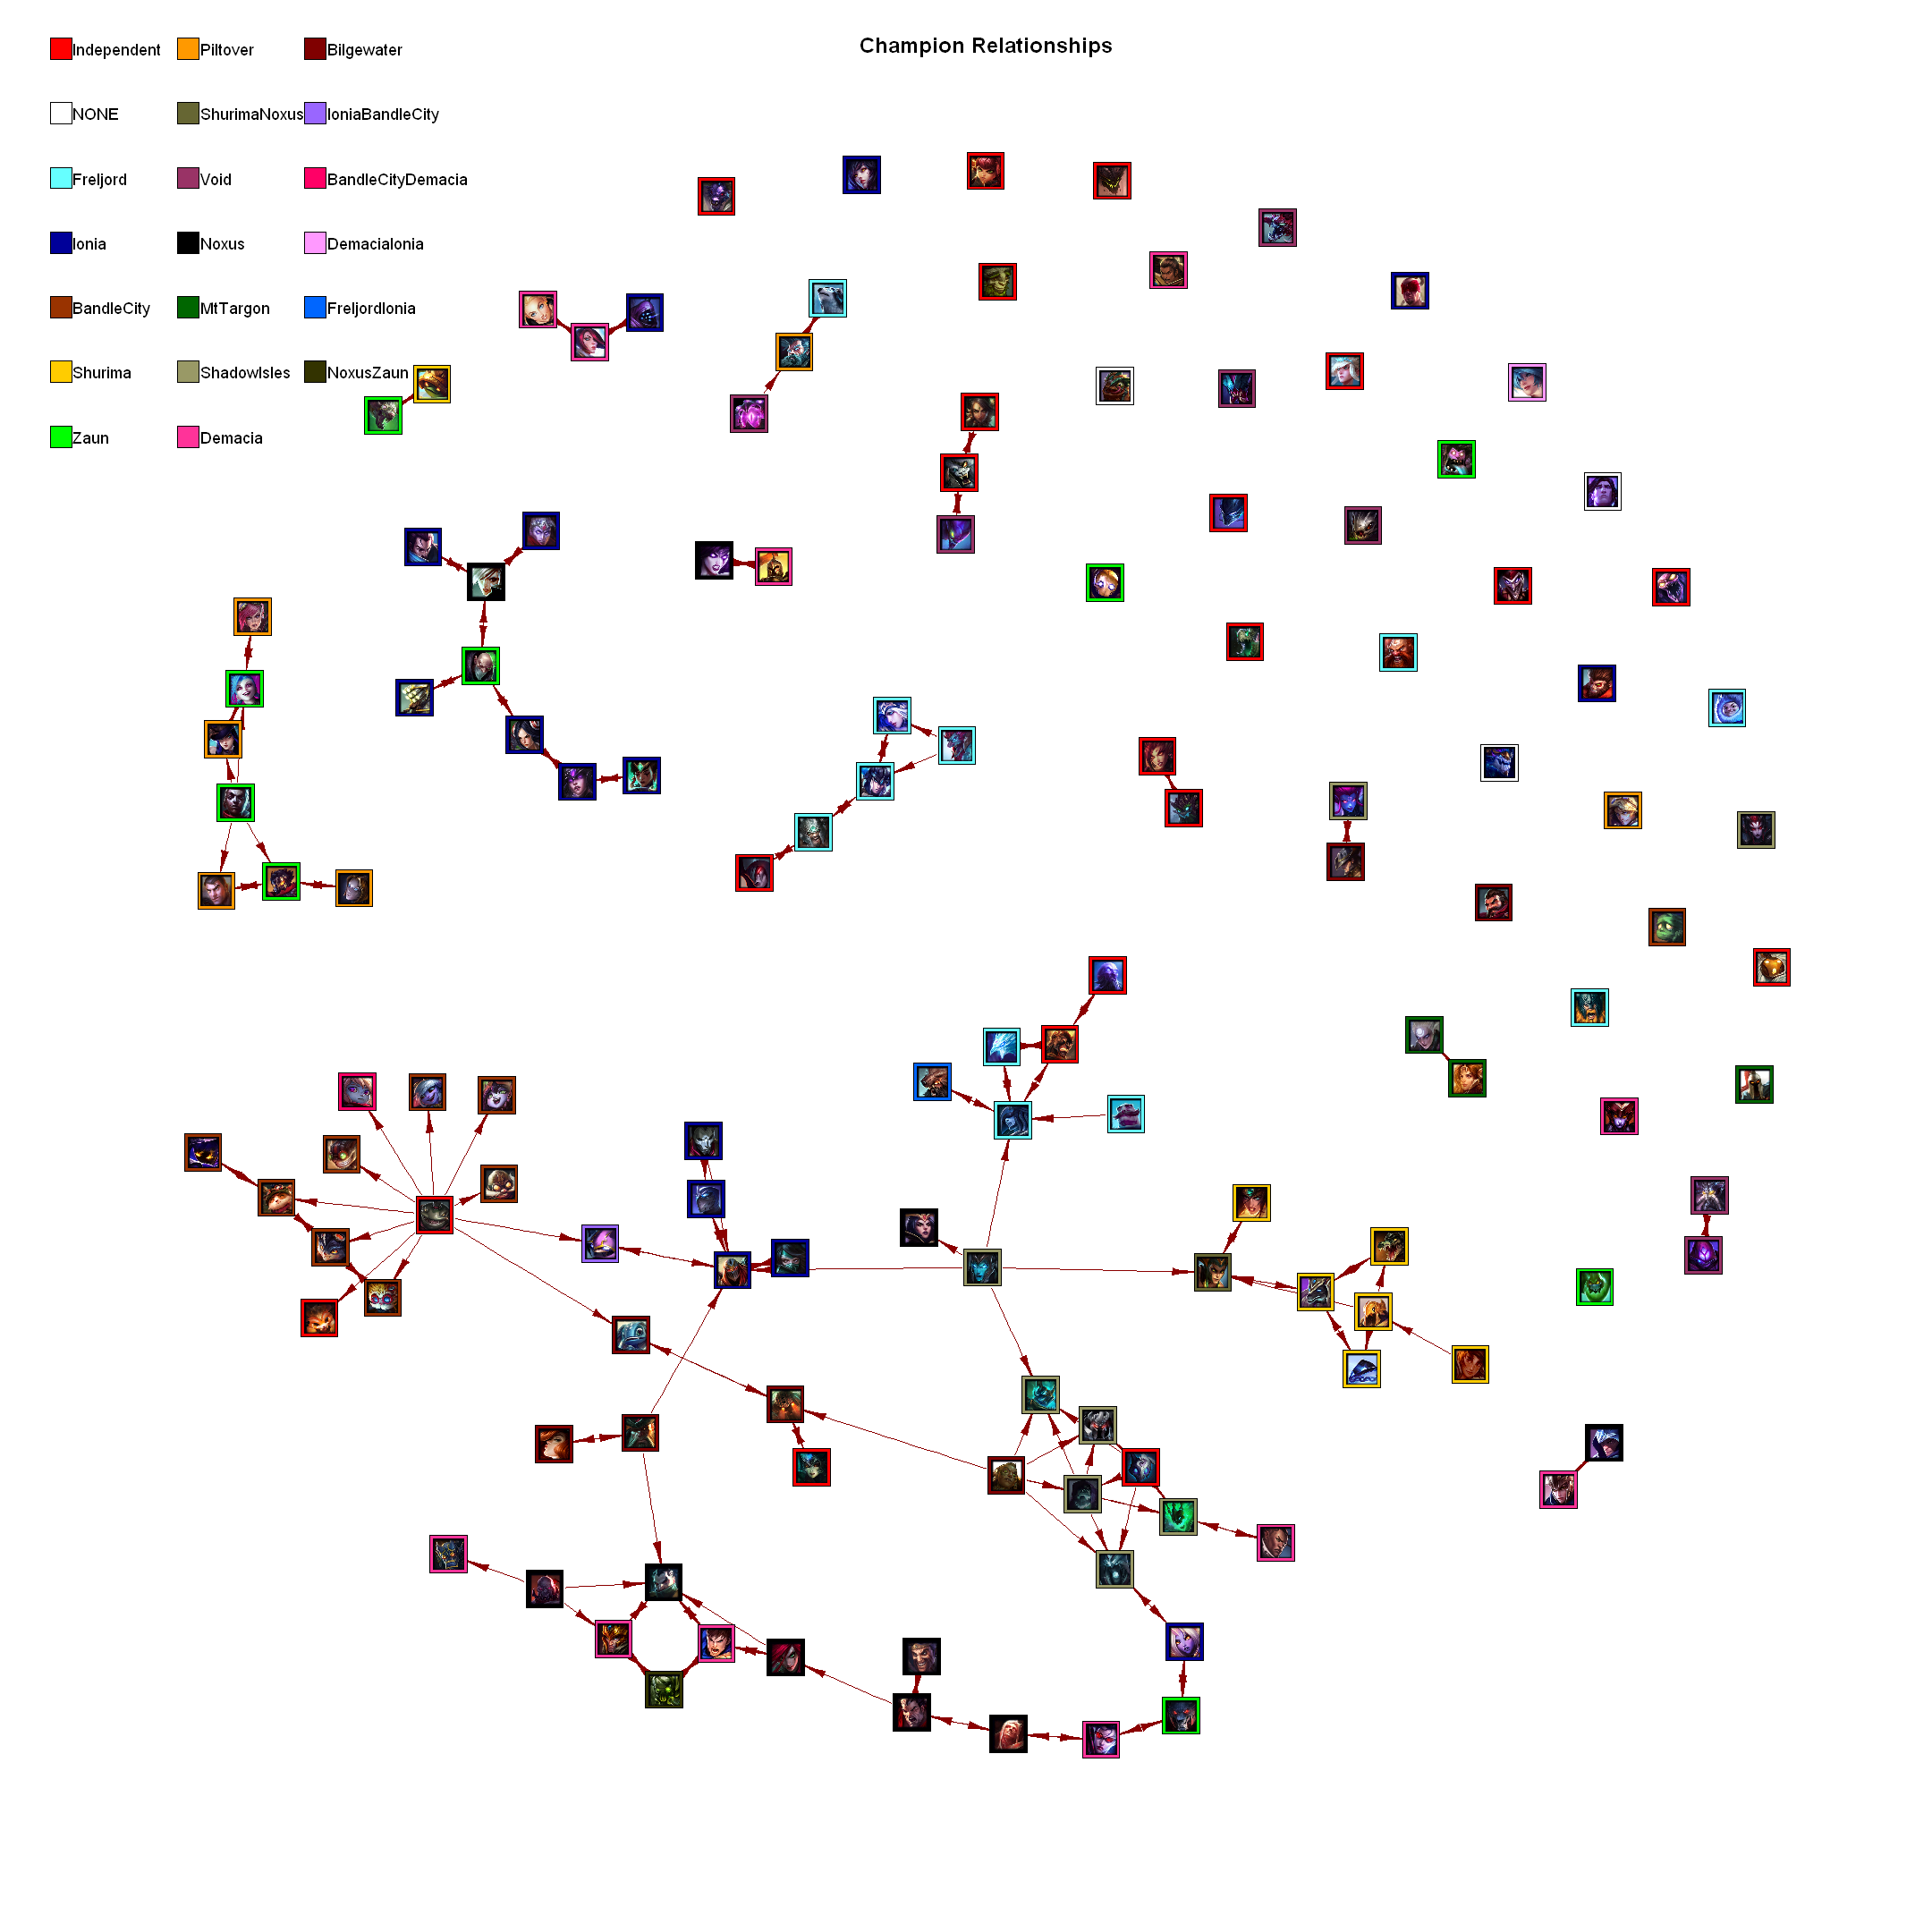

In [194]:
set.seed(1)
# arrows point to x is friends with

rnk = rivals - "kled"

l <- layout.norm(layout.fruchterman.reingold(rnk, niter = 500))


V(rnk)$label.cex <- .01
E(rnk)$arrow.size <- .3
E(rnk)$arrow.width <- .5
V(rnk)$size <- 4.75
V(rnk)$shape <- "square"

plot(rnk, layout = l, main = "Champion Relationships")

# get rid of kled image
path_to_kled = paste(path_to_files,"kled.png",sep="/")
imgfilename[match(path_to_kled, imgfilename)] <- NULL

img <- lapply(imgfilename, png::readPNG)

for(i in 1:nrow(l)) {  
  rasterImage(img[[i]], l[i, 1]-0.02, l[i, 2]-0.02, l[i, 1]+0.02, l[i, 2]+0.02)
}

legend("topleft", text.width=c(.085),
       inset = c(0, -.06), bty = "n", x.intersp=.25,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = .9, xpd = TRUE)

#### Both No Kled Image Graph

Here we remove kled from the graph to see what it would look like

Warning message in FUN(X[[i]], ...):
"libpng warning: iCCP: known incorrect sRGB profile"

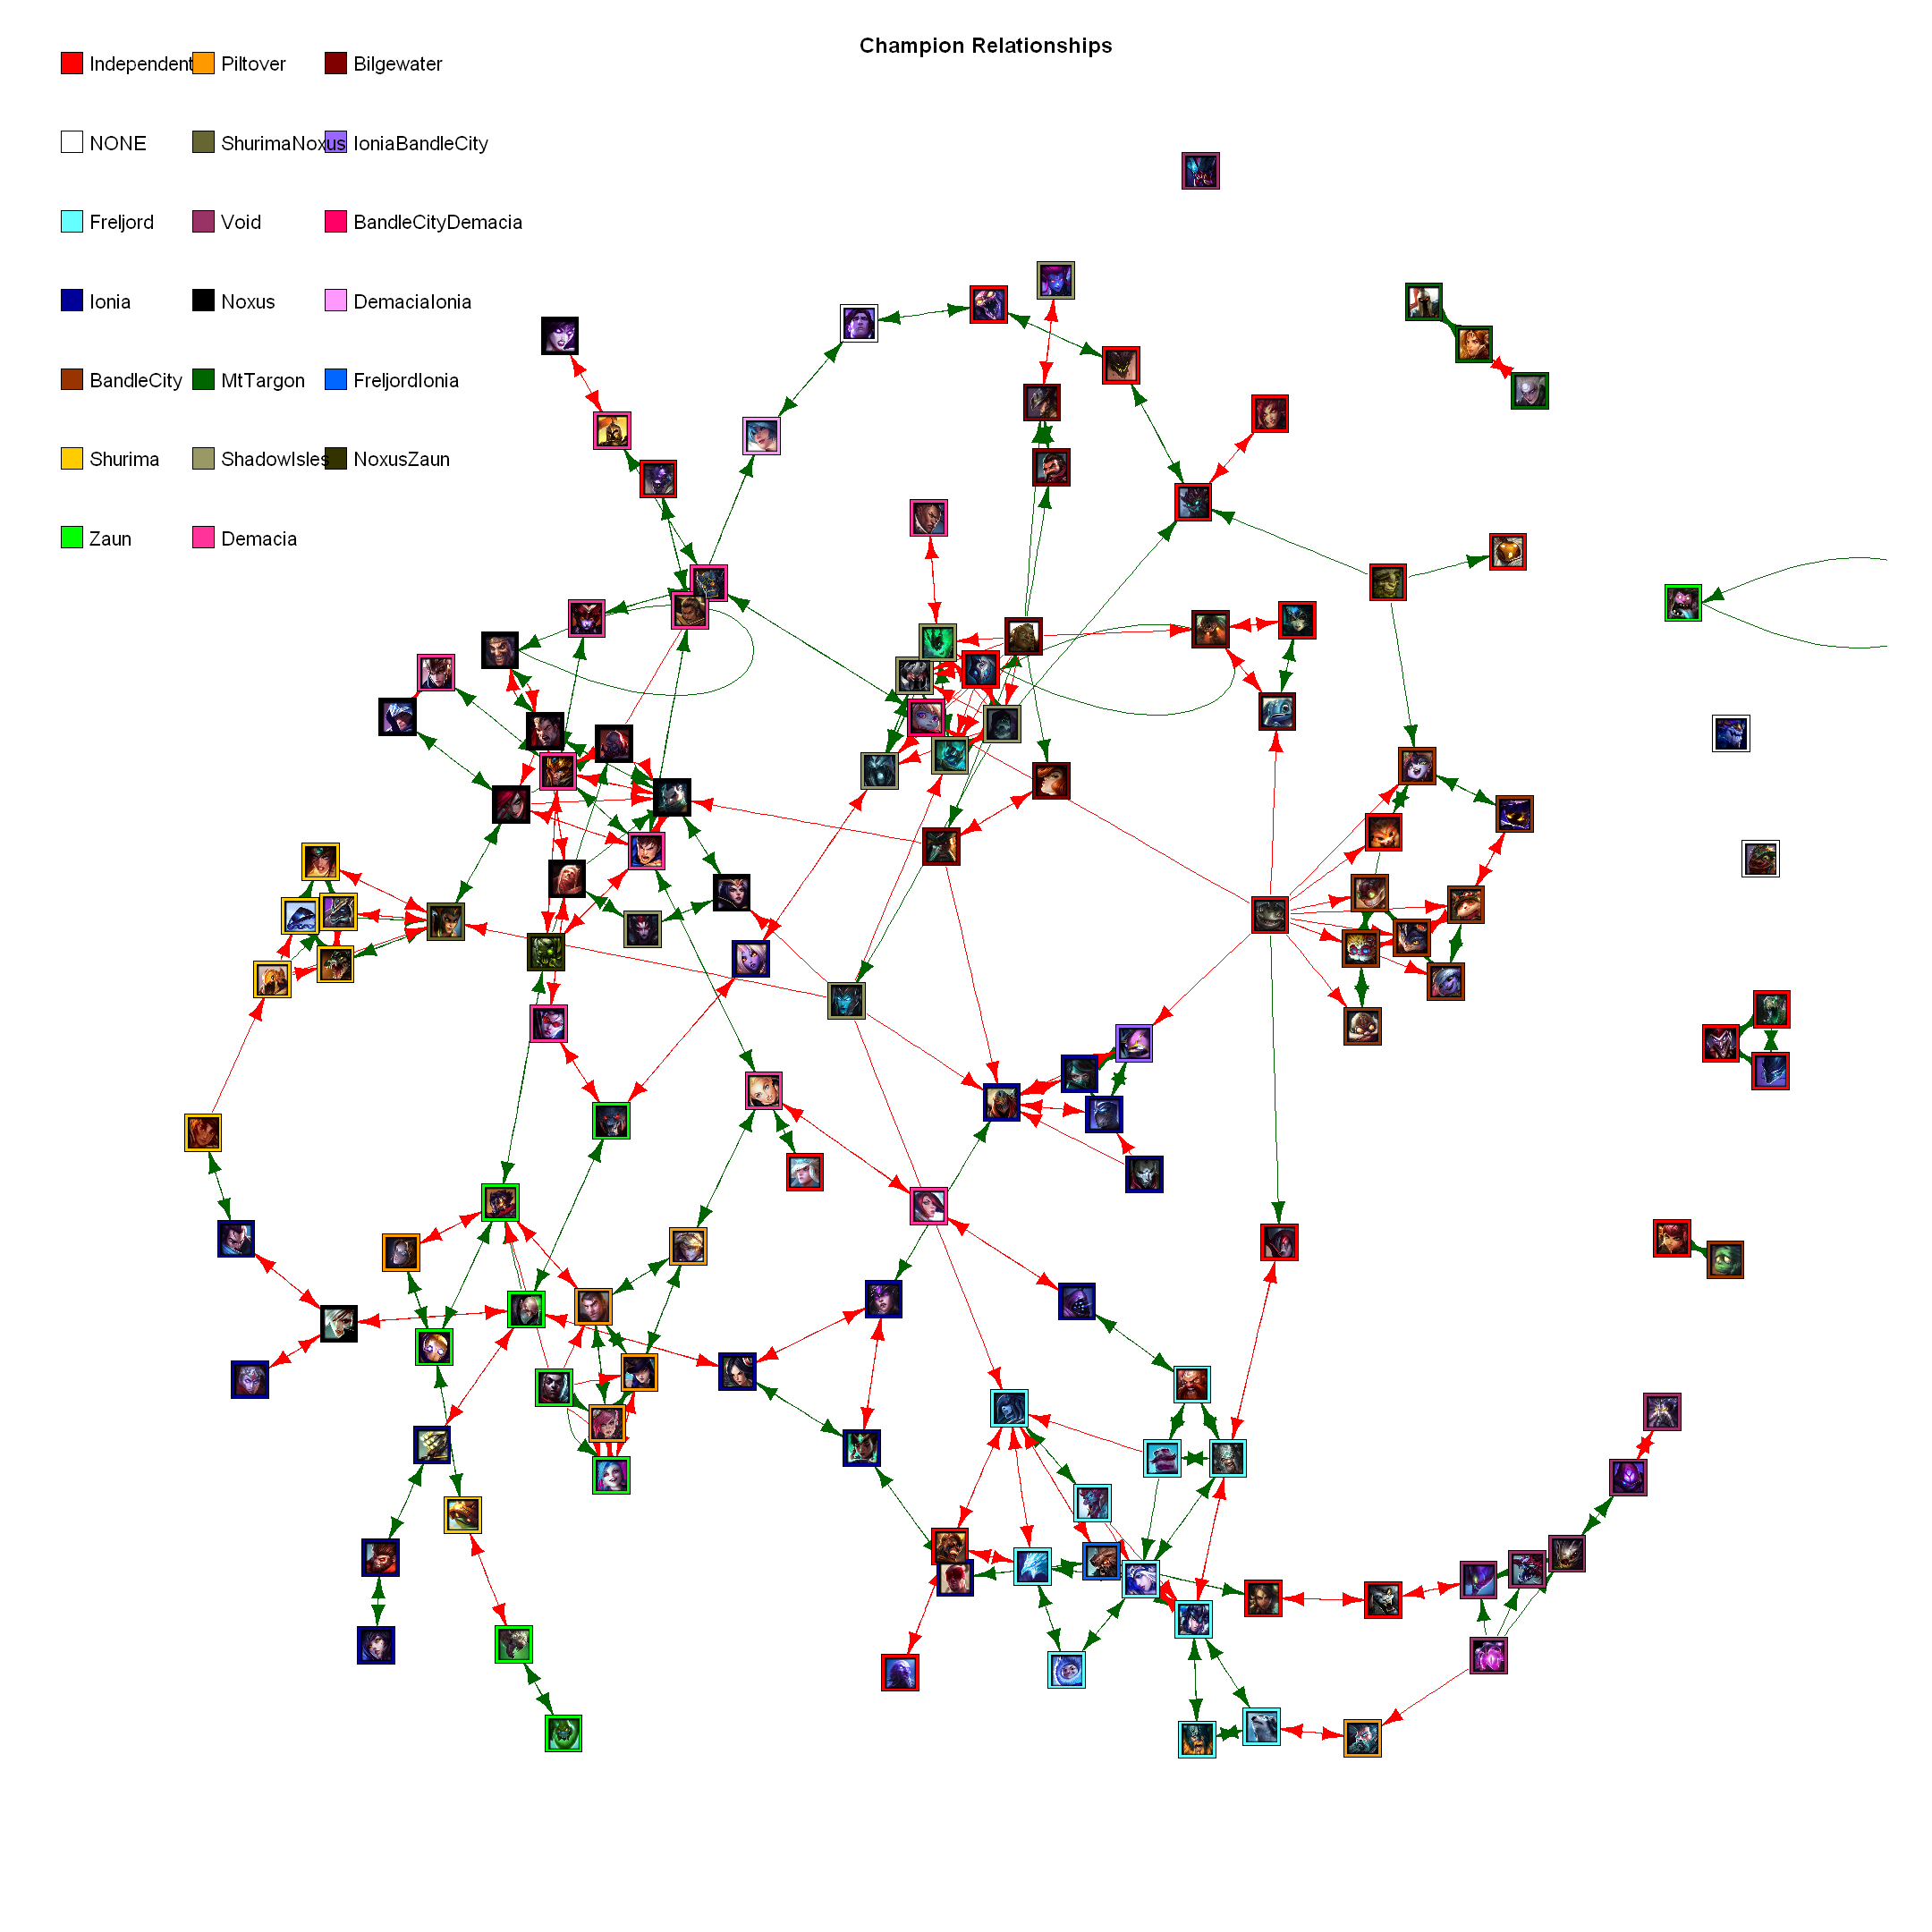

In [195]:
set.seed(1)

bnk = both - "kled"

l <- layout.norm(layout.fruchterman.reingold(bnk, niter = 500, start.temp = 20))

V(bnk)$label.cex <- .001
E(bnk)$arrow.size <- .3
E(bnk)$arrow.width <- 1
V(bnk)$size <- 4.75
V(bnk)$shape <- "square"


plot(bnk, layout = l, main = "Champion Relationships")


img <- lapply(imgfilename, png::readPNG)

for(i in 1:nrow(l)) {
  rasterImage(img[[i]], l[i, 1]-0.02, l[i, 2]-0.02, l[i, 1]+0.02, l[i, 2]+0.02)
}
 
legend("topleft", text.width=c(.07),
       inset = c(0, -.06), bty = "n", x.intersp=.3,
       xjust=0, yjust=0,
       legend= legendAllFactions,
       pt.bg=factionColors,
       ncol = 3,
       pch=22, pt.cex = 3,
       cex = 1.1, xpd = TRUE)
